# Analisis Visual dan Prediksi AI pada Dataset Netflix Shows
## *Visual Analystics and AI Prediction on Netflix Shows Dataset*

## Tujuan Projek
- Mengidentifikasi genre tayangan paling dominan sepanjang waktu dalam katalog Netflix.
- Menelusuri tren perkembangan genre dari tahun ke tahun.
- Memprediksi genre-genre yang akan meningkat popularitasnya hingga lima tahun ke depan (2022–2026).
- Membangun model klasifikasi untuk memprediksi rating tayangan berdasarkan genre dan tipe konten.
- Menampilkan perbandingan antara rating aktual dan hasil prediksi sebagai evaluasi model AI.
- Menganalisis hubungan antara genre dan klasifikasi rating untuk melihat pola keterkaitan atau dominasi.

### Model AI yang Digunakan
- Random Forest Classifier
- Linear Regresssion

### Import Library

In [7]:
# Library utama
import pandas as pd
import numpy as np
from datetime import datetime

# Visualisasi
from bokeh.io import output_notebook, show
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, HoverTool, FactorRange, ColorBar, LinearColorMapper, Slider, CustomJS, Legend, LegendItem
from bokeh.transform import cumsum, factor_cmap, transform, dodge
from bokeh.layouts import row, column
from bokeh.palettes import Category20c, Category10, Viridis256


# Machine Learning
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression

# Aktifkan output Bokeh di notebook
output_notebook()


Loading BokehJS ...

### Visualisasi Top 10 Genre

In [8]:
df = pd.read_csv("C:\Tugas_Materi Kuliah\S6\Visualisasi Data\Tugas Besar\Dataset Netflix Shows.csv")
df['genre_list'] = df['listed_in'].apply(lambda x: [g.strip() for g in x.split(',')])
genre_df = df.explode('genre_list')
top_genres = genre_df['genre_list'].value_counts().head(10)

source = ColumnDataSource(data=dict(
    genres=top_genres.index[::-1].tolist(),
    counts=top_genres.values[::-1]
))

p1 = figure(y_range=top_genres.index[::-1].tolist(), height=400, width=600, 
            title="Top 10 Genre Sepanjang Tahun", tools="hover", 
            tooltips=[("Genre", "@genres"), ("Jumlah", "@counts")])
p1.hbar(y='genres', right='counts', height=0.5, source=source, color="navy")

show(p1)


In [ ]:
# — Preprocessing genre —
df['genre'] = df['listed_in'].fillna('Unknown').str.split(', ')
genre_df = df.explode('genre')

# — Tentukan Top-10 genre sepanjang waktu —
top_genres = (
    genre_df['genre']
      .value_counts()
      .head(10)
      .index
      .tolist()
)

# — Hitung jumlah rilis per (tahun, genre) hanya untuk Top-10 —
genre_year = (
    genre_df[genre_df['genre'].isin(top_genres)]
      .groupby(['release_year','genre'])
      .size()
      .reset_index(name='count')
)

# — Pastikan setiap (tahun,genre) kombinasi ada (fill 0) —
years = genre_year['release_year'].unique()
full_idx = pd.MultiIndex.from_product([years, top_genres], names=['release_year','genre'])
genre_year = (
    genre_year
      .set_index(['release_year','genre'])
      .reindex(full_idx, fill_value=0)
      .reset_index()
)

# — Buat interactive bar chart dengan slider tahun —
fig = px.bar(
    genre_year,
    x='genre',
    y='count',
    color='genre',
    animation_frame='release_year',
    animation_group='genre',
    category_orders={'genre': top_genres},
    range_y=[0, genre_year['count'].max()*1.1],
    title='Top 10 Genre Netflix per Tahun',
    labels={'count':'Jumlah Rilis', 'genre':'Genre', 'release_year':'Tahun Rilis'}
)

fig.update_layout(
    xaxis_tickangle=-45,
    legend_title_text='Genre',
    template='plotly_dark',
    height=600,
)
fig.update_xaxes(tickfont=dict(size=10), automargin=True)

fig.show()

### Prediksi Popularitas Genre (2022-2026)

In [10]:
# Load Dataset
df = pd.read_csv('Dataset Netflix Shows.csv')
df = df.dropna(subset=['listed_in', 'release_year'])
df['release_year'] = pd.to_numeric(df['release_year'], errors='coerce').astype(int)
df = df[df['release_year'] <= 2021]
df['genre'] = df['listed_in'].str.split(', ')
df = df.explode('genre')

# Top 10 Genre
top10_genre = df['genre'].value_counts().head(10).index.tolist()
genre_df = df[df['genre'].isin(top10_genre)]

# Hitung jumlah tayangan per genre per tahun
genre_year = genre_df.groupby(['release_year', 'genre']).size().reset_index(name='count')

# Prediksi untuk tahun 2022–2026
future_years = np.array(range(2022, 2027)).reshape(-1, 1)
plot_data = {'year': [str(y) for y in range(2022, 2027)]}
colors = Category10[10]

# Bersihkan nama genre untuk jadi kolom valid
genre_clean_map = {g: g.replace(' ', '_').replace('&', 'and').replace('-', '_') for g in top10_genre}

# Prediksi tiap genre
for genre in top10_genre:
    data = genre_year[genre_year['genre'] == genre]
    clean_name = genre_clean_map[genre]
    if len(data) > 1:
        X = data['release_year'].values.reshape(-1, 1)
        y = data['count'].values
        model = LinearRegression()
        model.fit(X, y)
        pred = model.predict(future_years)
        pred = np.clip(pred, 0, None)
        plot_data[clean_name] = np.round(pred).astype(int)
    else:
        plot_data[clean_name] = [0] * len(future_years)

# Siapkan sumber data
source = ColumnDataSource(plot_data)

# Buat Figure
p = figure(title="Prediksi Popularitas Genre (2022–2026)",
           x_range=plot_data['year'], height=450, width=900,
           x_axis_label='Tahun', y_axis_label='Jumlah Tayangan',
           tools="pan,wheel_zoom,box_zoom,reset,save")

# Tambahkan line dan scatter
legend_items = []
for i, genre in enumerate(top10_genre):
    clean_name = genre_clean_map[genre]
    line = p.line(x='year', y=clean_name, source=source, line_width=2, color=colors[i])
    scatter = p.scatter(x='year', y=clean_name, source=source, size=6, color=colors[i])

    # Tooltip
    hover = HoverTool(renderers=[scatter],
                      tooltips=[("Genre", genre),
                                ("Tahun", "@year"),
                                ("Jumlah Tayangan", f"@{clean_name}")])
    p.add_tools(hover)

    legend_items.append(LegendItem(label=genre, renderers=[line]))

# Tambahkan legend
legend = Legend(items=legend_items, location="center")
p.add_layout(legend, 'right')
p.legend.click_policy = "hide"

show(p)


### Visualisasi Top 10 Rating

In [11]:
rating_counts = df['rating'].value_counts().head(10)
source = ColumnDataSource(data=dict(
    ratings=list(rating_counts.index),
    counts=list(rating_counts.values)
))

p4 = figure(x_range=list(rating_counts.index), height=400, width=600, title="10 Rating Paling Banyak Muncul", tools="hover", tooltips=[("Rating", "@ratings"), ("Jumlah", "@counts")])
p4.vbar(x='ratings', top='counts', width=0.6, source=source, color="orange")
show(p4)


In [12]:
top10_ratings = df['rating'].value_counts().head(10).index.tolist()


### Visualisasi Rating Aktual vs Prediksi & Confusion Matrix

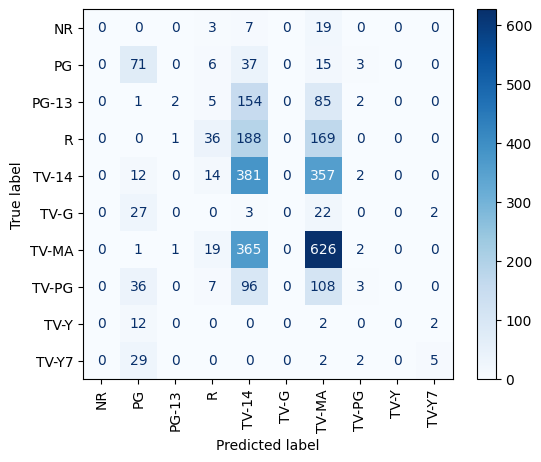

In [13]:
# Label Encoding
df_rating = df[df['rating'].isin(rating_counts.index)].copy()
df_rating['encoded_genre'] = df_rating['listed_in'].apply(lambda x: x.split(',')[0])
le = LabelEncoder()
df_rating['label'] = le.fit_transform(df_rating['rating'])

X = pd.get_dummies(df_rating[['encoded_genre', 'type']])
y = df_rating['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(xticks_rotation=90, cmap="Blues")


# Histogram (Actual vs Predicted)
actual_counts = pd.Series(y_test).map(lambda i: le.classes_[i]).value_counts()
predicted_counts = pd.Series(y_pred).map(lambda i: le.classes_[i]).value_counts()

source = ColumnDataSource(data=dict(
    ratings=actual_counts.index,
    actual=actual_counts.values,
    predicted=[predicted_counts.get(r, 0) for r in actual_counts.index]
))

# Custom hover tool
hover = HoverTool(tooltips=[("Rating", "@ratings"),("Jumlah Aktual", "@actual"),("Jumlah Prediksi", "@predicted")])
p_hist = figure(x_range=actual_counts.index.tolist(), height=400, width=700, title="Distribusi Rating: Aktual vs Prediksi", tools=[hover, "pan", "wheel_zoom", "box_zoom", "reset", "save"])
p_hist.vbar(x=dodge('ratings', -0.2, range=p_hist.x_range), top='actual', width=0.4, source=source, color="green", legend_label="Aktual")
p_hist.vbar(x=dodge('ratings', 0.2, range=p_hist.x_range), top='predicted', width=0.4, source=source, color="red", legend_label="Prediksi")
p_hist.legend.location = "top_right"
show(p_hist)


### Korelasi Genre dan Rating
Pembuatan visualisasi korelasi genre dan rating adalah untuk menganalisis
1. Apakah genre tertentu cenderung memiliki rating tinggi atau rendah? 
2. Apakah ada genre yang mendominasi pada tayangan dengan rating tertentu?

In [14]:
# Siapkan data genre-rating
genre_rating = df.dropna(subset=['listed_in', 'rating']).copy()
genre_rating = genre_rating.assign(genre=genre_rating['listed_in'].str.split(', ')).explode('genre')
genre_rating = genre_rating[genre_rating['genre'].isin(top10_genre)]
genre_rating = genre_rating[genre_rating['rating'].isin(top10_ratings)]

# Pivot table: genre vs rating
pivot = genre_rating.groupby(['genre', 'rating']).size().unstack(fill_value=0)

ratings = pivot.columns.tolist()
genres = pivot.index.tolist()
colors = Category10[len(ratings)]

# Format data untuk ColumnDataSource
source_data = {'genre': genres}
for r in ratings:
    source_data[r] = pivot[r].values
source = ColumnDataSource(data=source_data)

# Bokeh stacked horizontal bar chart
p = figure(y_range=genres, height=500, width=800, title="Distribusi Genre terhadap Rating (Stacked Bar)",
           tools="hover", tooltips="$name @genre: @$name", toolbar_location="above")

p.hbar_stack(ratings, y='genre', height=0.8, color=colors, source=source, legend_label=ratings)

p.xaxis.axis_label = 'Jumlah Tayangan'
p.yaxis.axis_label = 'Genre'
p.legend.title = 'Rating'
p.legend.location = "center_right"
p.legend.label_text_font_size = "10pt"

show(p)
